# CNN With Some Data Augmentation
## Included some none defects in the data set and then performed data augmentation

This code is written to ingest WM811K dataset and get trained on defect patterns and be able to distinguish and group wafers into two groups - defect pattern vs no pattern. Data was resized to 60x60. Runs existing data defect patterns without any additional data added to rebalance class. 

This code performs some data augmentation of flips and rotation.
Source for data augmentation (Jie Gong and Chen Lin from Stanford): http://localhost:8888/tree/Downloads/CS230-Deep-Learning-master

Other Sources for base code:
1. Wafer defect classification by deep learning code: Ashadullah Shawon: https://www.kaggle.com/shawon10/wafer-defect-classification-by-deep-learning
2. Defect detection in wafer maps: Paul Bassaler: https://www.kaggle.com/paulbassaler/defect-detection-in-wafer-bin-maps
3. http://localhost:8888/tree/Downloads/CS230-Deep-Learning-master


In [2]:
import os
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

!pip install tensorflow
import tensorflow as tf
import keras
from keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Import modeling libraries.
import sklearn as sk
#sklearn.__version__
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
#from skimage.transform import resize as sk_resize

import skimage
from skimage.transform import rescale, resize, rotate
from skimage.util import img_as_float

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Write some functions to process images. Image normalization, resizing to 42x42. Flips and rotations of images

#defect density is calucated by counting how many pixel == 2 and divide by the size, this indicates that pixel = 2 is defect, 
#input argument x is the wafer map array 
def cal_den(x):
    return 100*(np.sum(x==2)/np.size(x))  

def imgNormResize(img):
    img_norm = img/2 #now it is float64 now
    image_resized = resize(img_norm, (42,42))
    return image_resized

#Flip array in the left/right direction.
def imgFliplr(img):
    return np.fliplr(img)    

#Flip array in the up/down direction.
def imgFlipud(img):
    return np.flipud(img)    

#image rotation

def imgRotate45(img):
    return rotate(img, 45)

def imgRotate90(img):
    return rotate(img, 90)

def imgRotate135(img):
    return rotate(img, 135)

def imgRotate180(img):
    return rotate(img, 180)

def imgRotate225(img):
    return rotate(img, 225)
    
def imgRotate270(img):
    return rotate(img, 270)
    
def imgRotate315(img):
    return rotate(img, 315)

#return the regions intensity, 
def find_regions(x):
    rows=np.size(x,axis=0)
    cols=np.size(x,axis=1)
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)
    
    reg1=x[ind1[0]:ind1[1],:]
    reg3=x[ind1[4]:,:]
    reg4=x[:,ind2[0]:ind2[1]]
    reg2=x[:,ind2[4]:]

    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]
    
    fea_reg_den = []
    fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
    return fea_reg_den

def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1


def change_val(img):
    img[img==1] =0  
    return img

In [4]:
# Read the full data file that is stored locally. Look at information and data details

df=pd.read_pickle("LSWMD.pkl")
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
362595,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1080.0,lot21701,10.0,[],[]
684521,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1194.0,lot42393,19.0,[[Test]],[[none]]
24213,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1253.0,lot2689,3.0,[],[]
671025,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",712.0,lot41773,8.0,[],[]
782516,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1414.0,lot46367,9.0,[[Test]],[[Edge-Loc]]


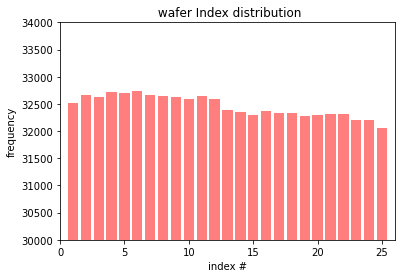

In [5]:
#WaferIndex column provides wafer numbers from 1 to 25
#From the distribution, number of wafers in each lot is not equal. 
#We do not use the wafer index details. So, it can be removed from dataset
uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='red', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

df = df.drop(['waferIndex'], axis = 1)

In [6]:
# From the dataset we have wafers with different die size and count. Look at details.
# waferMap value is a numpy array with 0, 1, 2 values. 0-no data, 1-pure pixel die, 2-defect die
# Create a new column titled waferMapDim that lists die size for each wafer
df['waferMapDim']=df.waferMap.apply(find_dim)
print(df.sample(5))

print("\nMaximum and minimum wafer map dimensions are: ", max(df.waferMapDim), min(df.waferMapDim))
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]

                                                 waferMap  dieSize   lotName  \
68155   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1129.0   lot5149   
792728  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2,...    562.0  lot46780   
183989  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   6275.0  lot11708   
295620  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   2479.0  lot18069   
39308   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    776.0   lot3516   

       trianTestLabel failureType waferMapDim  
68155              []          []    (39, 37)  
792728       [[Test]]    [[none]]    (29, 26)  
183989             []          []    (92, 87)  
295620             []          []    (72, 44)  
39308              []          []    (30, 34)  

Maximum and minimum wafer map dimensions are:  (300, 202) (6, 21)


632

In [7]:
# Re-arranging the data. Creating nuerical values for failure type and train/test type
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel

#create 2 dictionary, and replace failureType and trianTestLabel column with the new 2 columns using number instead of text, 
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

tol_wafers = df.shape[0]  #there are 811457 wafer points

# Split the database into three buckets: Wafers with labels, Wafers with pattern defect, Wafers without patterns
# Wafers with labels are wafers that have some defect label provided. This includes "none" category as well

df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()

df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()

df_nonpattern = df[(df['failureNum']==8)] 

print("Wafers with label", df_withlabel.shape[0])
print("Wafers with defect patterns", df_withpattern.shape[0])
print("Wafers without defect patterns", df_nonpattern.shape[0])

Wafers with label 172950
Wafers with defect patterns 25519
Wafers without defect patterns 147431


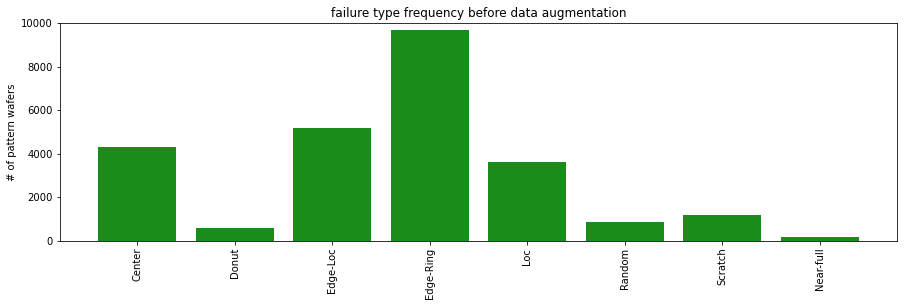

In [8]:
#Look at distribution of wafers with defect patterns across different patterns

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
plt.figure(figsize=(15,4))
plt.bar(uni_pattern[0], uni_pattern[1], color='green', align='center', alpha=0.9)
plt.title("failure type frequency before data augmentation")
#plt.xticks(labels2)
plt.xticks(uni_pattern[0], labels2, rotation='vertical')
plt.ylabel("# of pattern wafers")
plt.ylim(0,10000)
plt.show()

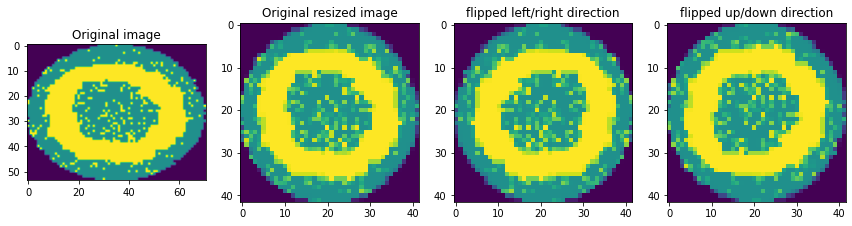

In [9]:
# Perform some simple checks with a donut image. Perform resizing to check.
# Perform some image flip 

idx = 340
img = df_withpattern.waferMap[idx]
img_norm = img/2
image_resized = imgNormResize(img)

#image_resized_flip = np.flip(image_resized, 0)
#image_resized_flip = np.flip(image_resized, 1) #Reverse the order of elements in an array along the given axis
image_resized_fliplr = np.fliplr(image_resized) #Flip array in the left/right direction.
image_resized_flipud = np.flipud(image_resized) #Flip array in the up/down direction.

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
ax = axes.ravel(order='C')

ax[0].imshow(img_norm)
ax[0].set_title("Original image")

ax[1].imshow(image_resized)
ax[1].set_title("Original resized image")

ax[2].imshow(image_resized_fliplr)
ax[2].set_title("flipped left/right direction")

ax[3].imshow(image_resized_flipud)
ax[3].set_title("flipped up/down direction")
plt.tight_layout()
plt.show()

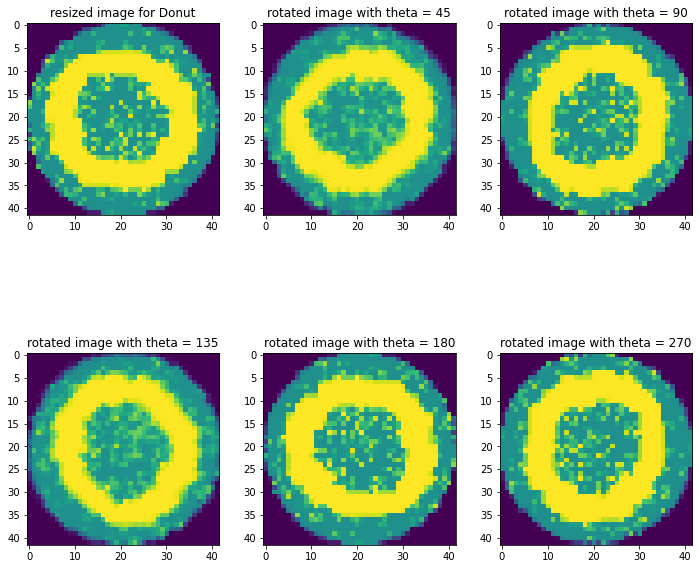

In [10]:
#Perform some image rotation exercise 
idx = 340
img = df_withpattern.waferMap[idx]
image_resized = imgNormResize(img)

angle = [45,90,135,180,270]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
ax = axes.ravel(order='C')

ax[0].imshow(image_resized)
ax[0].set_title("resized image for Donut")

for i in range(len(angle)):
    rotated = rotate(image_resized, angle[i], center=None)
    ax[i+1].imshow(rotated)
    ax[i+1].set_title("rotated image with theta = %d" % (angle[i]))
plt.tight_layout()
plt.show()

Number of wafers in nearfull category pre augmentation 149
Number of wafers in nearfull category after augmentation 1341
Number of wafers in donut category pre augmentation 555
Number of wafers in donut category after augmentation 2775


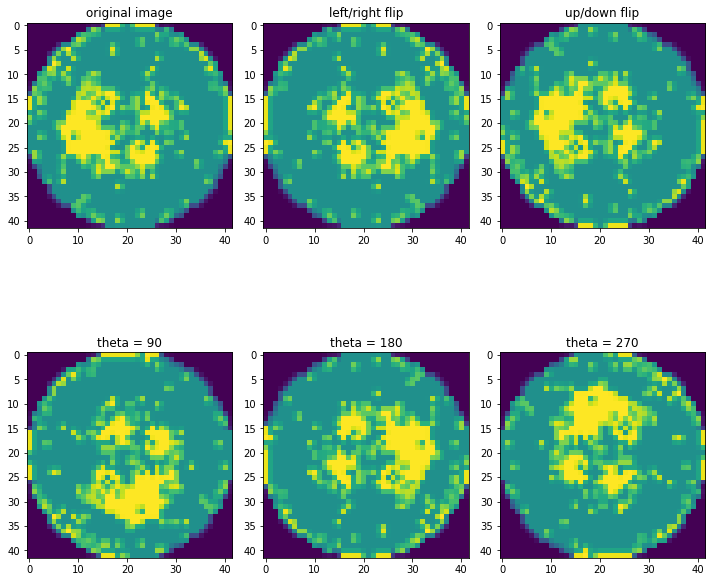

Number of wafers in random category pre augmentation 866
Number of wafers in random category after augmentation 4330
Number of wafers in scratch category pre augmentation 1193
Number of wafers in scratch category after augmentation 5965


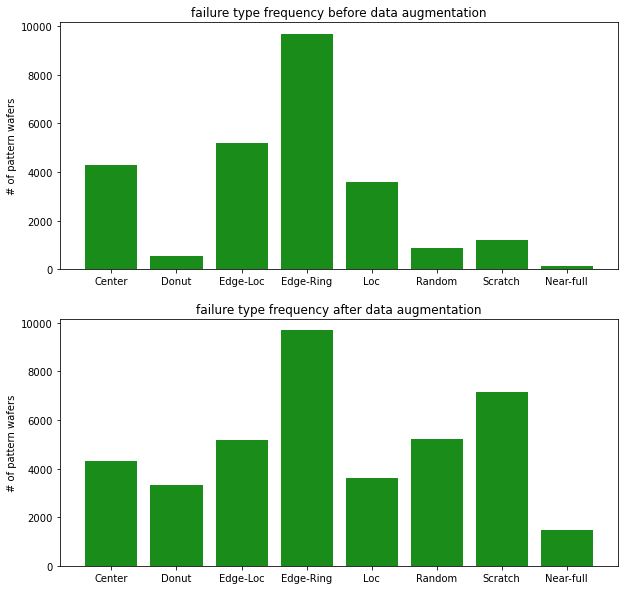

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25519 entries, 0 to 25518
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   waferMap           25519 non-null  object
 1   failureNum         25519 non-null  object
 2   augmentationLabel  25519 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 598.2+ KB
147431 144482
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42879 entries, 0 to 42878
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   waferMap           42879 non-null  object
 1   failureNum         42879 non-null  object
 2   augmentationLabel  42879 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1005.1+ KB
42879


In [11]:
# Normalize and resize the images to (42, 42) pixel size. Add into a waferMapResize column
df_withpattern['waferMapResize'] = df_withpattern.waferMap.apply(imgNormResize)

img = df_withpattern.waferMapResize[0]
assert(img.shape == (42,42))

# Data augumentation for several classes, and add the new row for the data frame 
# Based on histogram or original dataset, different failure type needs different augmentaion, 
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}

#Near full defect type augmnetation
df_nearfull = df_withpattern[(df_withpattern['failureNum']==7)]
df_nearfull = df_nearfull.reset_index()

df_nearfull_fliplr = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_nearfull_fliplr['waferMap'] = df_nearfull.waferMapResize.apply(imgFliplr)

df_nearfull_flipud = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_nearfull_flipud['waferMap'] = df_nearfull.waferMapResize.apply(imgFlipud)

#rotation, 
theta = np.arange(45,360,45)

df_nearfull_rotation_45 = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_nearfull_rotation_90 = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_nearfull_rotation_135 = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_nearfull_rotation_180 = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_nearfull_rotation_225 = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_nearfull_rotation_270 = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_nearfull_rotation_315 = pd.DataFrame(None, columns = ['waferMap','failureNum'])


df_nearfull_rotation_45['waferMap'] = df_nearfull.waferMapResize.apply(imgRotate45)
df_nearfull_rotation_90['waferMap'] = df_nearfull.waferMapResize.apply(imgRotate90)
df_nearfull_rotation_135['waferMap'] = df_nearfull.waferMapResize.apply(imgRotate135)
df_nearfull_rotation_180['waferMap'] = df_nearfull.waferMapResize.apply(imgRotate180)
df_nearfull_rotation_225['waferMap'] = df_nearfull.waferMapResize.apply(imgRotate225)
df_nearfull_rotation_270['waferMap'] = df_nearfull.waferMapResize.apply(imgRotate270)
df_nearfull_rotation_315['waferMap'] = df_nearfull.waferMapResize.apply(imgRotate315)

df_nearfull_augmentation = pd.concat([df_nearfull_fliplr, df_nearfull_flipud, df_nearfull_rotation_45, \
                            df_nearfull_rotation_90, df_nearfull_rotation_135, df_nearfull_rotation_180, \
                            df_nearfull_rotation_225, df_nearfull_rotation_270, df_nearfull_rotation_315],axis=0,ignore_index=True)


df_nearfull_augmentation['failureNum'] = 7
num_nearfull_augmentation = df_nearfull_augmentation.shape[0]

print("Number of wafers in nearfull category pre augmentation", df_nearfull.shape[0])
print("Number of wafers in nearfull category after augmentation", num_nearfull_augmentation)

#Perform augmentation for donut same manner
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}

df_donut = df_withpattern[(df_withpattern['failureNum']==1)]
df_donut = df_donut.reset_index()
num_donut = df_donut.shape[0]

df_donut_fliplr = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_donut_fliplr['waferMap'] = df_donut.waferMapResize.apply(imgFliplr)

df_donut_flipud = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_donut_flipud['waferMap'] = df_donut.waferMapResize.apply(imgFlipud)

df_donut_rotation_90 = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_donut_rotation_180 = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_donut_rotation_270 = pd.DataFrame(None, columns = ['waferMap','failureNum'])

df_donut_rotation_90['waferMap'] = df_donut.waferMapResize.apply(imgRotate90)
df_donut_rotation_180['waferMap'] = df_donut.waferMapResize.apply(imgRotate180)
df_donut_rotation_270['waferMap'] = df_donut.waferMapResize.apply(imgRotate270)

df_donut_augmentation = pd.concat([df_donut_fliplr, df_donut_flipud, df_donut_rotation_90, \
                            df_donut_rotation_180, df_donut_rotation_270],axis=0,ignore_index=True)
    
df_donut_augmentation['failureNum'] = 1
num_donut_augmentation = df_donut_augmentation.shape[0]

print("Number of wafers in donut category pre augmentation", df_donut.shape[0])
print("Number of wafers in donut category after augmentation", num_donut_augmentation)

#Plot the images to see whether augmentation is done correctly
labels_donut = ['original image','left/right flip','up/down flip','theta = 90','theta = 180','theta = 270']
numLabels_donut = len(labels_donut)
nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(10, 10))
ax = ax.ravel(order='C')

startIdx = 0;
img = df_donut.waferMapResize[startIdx]
ax[0].imshow(img)
ax[0].set_title(labels_donut[0])

img = df_donut_fliplr.waferMap[startIdx]
ax[1].imshow(img)
ax[1].set_title(labels_donut[1])

img = df_donut_flipud.waferMap[startIdx]
ax[2].imshow(img)
ax[2].set_title(labels_donut[2])

img = df_donut_rotation_90.waferMap[startIdx]
ax[3].imshow(img)
ax[3].set_title(labels_donut[3])

img = df_donut_rotation_180.waferMap[startIdx]
ax[4].imshow(img)
ax[4].set_title(labels_donut[4])

img = df_donut_rotation_270.waferMap[startIdx]
ax[5].imshow(img)
ax[5].set_title(labels_donut[5])

plt.tight_layout()
plt.show() 

#Data augmentation for random 
df_random = df_withpattern[(df_withpattern['failureNum']==5)]
df_random = df_random.reset_index()
num_random = df_random.shape[0]

df_random_fliplr = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_random_fliplr['waferMap'] = df_random.waferMapResize.apply(imgFliplr)

df_random_flipud = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_random_flipud['waferMap'] = df_random.waferMapResize.apply(imgFlipud)

df_random_rotation_90 = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_random_rotation_180 = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_random_rotation_270 = pd.DataFrame(None, columns = ['waferMap','failureNum'])

df_random_rotation_90['waferMap'] = df_random.waferMapResize.apply(imgRotate90)
df_random_rotation_180['waferMap'] = df_random.waferMapResize.apply(imgRotate180)
df_random_rotation_270['waferMap'] = df_random.waferMapResize.apply(imgRotate270)

df_random_augmentation = pd.concat([df_random_fliplr, df_random_flipud, df_random_rotation_90, \
                            df_random_rotation_180, df_random_rotation_270],axis=0,ignore_index=True)

df_random_augmentation['failureNum'] = 5
num_random_augmentation = df_random_augmentation.shape[0]

print("Number of wafers in random category pre augmentation", df_random.shape[0])
print("Number of wafers in random category after augmentation", num_random_augmentation)

#Data augmentation for scratch defect 
df_scratch = df_withpattern[(df_withpattern['failureNum']==6)]
df_scratch = df_scratch.reset_index()
num_scratch = df_scratch.shape[0]

df_scratch_fliplr = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_scratch_fliplr['waferMap'] = df_scratch.waferMapResize.apply(imgFliplr)

df_scratch_flipud = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_scratch_flipud['waferMap'] = df_scratch.waferMapResize.apply(imgFlipud)

df_scratch_rotation_90 = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_scratch_rotation_180 = pd.DataFrame(None, columns = ['waferMap','failureNum'])
df_scratch_rotation_270 = pd.DataFrame(None, columns = ['waferMap','failureNum'])

df_scratch_rotation_90['waferMap'] = df_scratch.waferMapResize.apply(imgRotate90)
df_scratch_rotation_180['waferMap'] = df_scratch.waferMapResize.apply(imgRotate180)
df_scratch_rotation_270['waferMap'] = df_scratch.waferMapResize.apply(imgRotate270)

df_scratch_augmentation = pd.concat([df_scratch_fliplr, df_scratch_flipud, df_scratch_rotation_90, \
                            df_scratch_rotation_180, df_scratch_rotation_270],axis=0,ignore_index=True)

df_scratch_augmentation['failureNum'] = 6
num_scratch_augmentation = df_scratch_augmentation.shape[0]

print("Number of wafers in scratch category pre augmentation", df_scratch.shape[0])
print("Number of wafers in scratch category after augmentation", num_scratch_augmentation)

#Plot the defect histograms pre and post data augmentation 
uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
uni_pattern_augmentation = list(uni_pattern[1])
uni_pattern_augmentation[1] = uni_pattern_augmentation[1] + num_donut_augmentation
uni_pattern_augmentation[5] = uni_pattern_augmentation[5] + num_random_augmentation
uni_pattern_augmentation[6] = uni_pattern_augmentation[6] + num_scratch_augmentation
uni_pattern_augmentation[7] = uni_pattern_augmentation[7] + num_nearfull_augmentation

nrows = 2
ncols = 1
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(10, 10))
ax = ax.ravel(order='C')

ax[0].bar(uni_pattern[0],uni_pattern[1], color='green', align='center', alpha=0.9)
assert (np.sum(uni_pattern[1]) == df_withpattern.shape[0])
ax[0].set_title("failure type frequency before data augmentation")
ax[0].set_ylabel("# of pattern wafers")
ax[0].set_xticklabels(labels2)

ax[1].bar(uni_pattern[0],uni_pattern_augmentation, color='green', align='center', alpha=0.9)
ax[1].set_title("failure type frequency after data augmentation")
ax[1].set_ylabel("# of pattern wafers")
ax[1].set_xticklabels(labels2)

plt.show()

#reduce data size, only need to save new image and data number

df_augmentation = pd.concat([df_scratch_augmentation, df_random_augmentation, df_nearfull_augmentation, \
                            df_donut_augmentation],axis=0,ignore_index=True)
num_augmentation = df_augmentation.shape[0]

#add a column to indicate it is from augmentation
df_augmentation['augmentationLabel'] = 1

#extract non-augmentation data, 
df_raw = pd.DataFrame(None, columns = ['waferMap','failureNum','augmentationLabel'])

df_raw['waferMap'] = df_withpattern['waferMapResize']
df_raw['failureNum'] = df_withpattern['failureNum']
df_raw['augmentationLabel'] = 0
df_raw.info()
df_raw.head()
df_raw.tail()

#Select labeled data and throw away 98% of none defects at random. Create smaller dataframe
N=int(0.98*(df_nonpattern.shape[0])) #98% of 172950 data points. Throw this away at random
print(df_nonpattern.shape[0], N)
df_none_defect = df_nonpattern.drop(df_nonpattern[df_nonpattern['failureNum'].eq(8)].sample(N).index)
df_none = pd.DataFrame(None, columns = ['waferMap','failureNum','augmentationLabel'])
df_none_defect['waferMapResize'] = df_none_defect.waferMap.apply(imgNormResize)
df_none['waferMap'] = df_none_defect['waferMapResize']
df_none['failureNum'] = df_none_defect['failureNum']
df_none['augmentationLabel'] = 0

df_output = pd.concat([df_raw, df_none, df_augmentation],axis=0,ignore_index=True)

df_output.info()
df_output.head()
df_output.tail()
num_df_output = df_output.shape[0]
#assert(num_df_output == sum(uni_pattern_augmentation))
print(num_df_output)

df_output.to_pickle("processed_pattern_data_2.pkl")

In [12]:
# Read the processed data file

df=pd.read_pickle("processed_pattern_data_2.pkl")
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42879 entries, 0 to 42878
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   waferMap           42879 non-null  object
 1   failureNum         42879 non-null  object
 2   augmentationLabel  42879 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1005.1+ KB


,waferMap,failureNum,augmentationLabel
5701,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3,0
12386,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3,0
40696,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,1
9818,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0
42136,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,1


In [13]:
Imlist = np.ones((1, 42, 42))
label = []

for i in range(len(df)):
    Imlist = np.concatenate((Imlist, df.iloc[i,:]['waferMap'].reshape(1, 42, 42)))
    label.append(df.iloc[i,:]['failureNum'])
    
#The first elemet in Imlist is just composed with ones, so it isn't intersesting, let's remove it
Imlist=Imlist[1:]
label=np.array(label).reshape((-1,1)) #Column of labels

#We have all the values of the pixels: 0.0 is for the exterior ofthe wafer map
#2.0 is for the local impure pixel and 1.0 is for a pure pixel of the wafer map

print(np.shape(Imlist),np.shape(label))

(42879, 42, 42) (42879, 1)


In [14]:
# Imlist is a numpy array with wafermap entries. Each entry has 42 rows and 42 columns
# We now turn all this data into a single column of data
# Each pixel value of each image is now separate and we can use it separately to process deep learning
Imlist_redo=Imlist.reshape((-1,42,42,1)) 
print(np.shape(Imlist_redo), len(Imlist_redo))

# In order to process deep learning, we have to use data composed by 1 only. In other words we have to
# change the data of 0-blank, 1-clean diw, 2- defect die into a data set composed of 1 only. We have to
# transform the dataset into a sequence of 1s for deep learning.
# for 0.0 we will use [1, 0, 0]
# for 1.0 we will use [0, 1, 0]
# for 2.0 we will use [0, 0, 1]

new_Imlist = np.zeros((len(Imlist_redo), 42, 42, 3)) 

for w in range(len(Imlist_redo)):
    for i in range(42):
        for j in range(42):
            new_Imlist[w, i, j, int(Imlist_redo[w, i, j])] = 1

print("New_Imlist shape", np.shape(new_Imlist))

(42879, 42, 42, 1) 42879
New_Imlist shape (42879, 42, 42, 3)


In [15]:
new_Imlist_original = new_Imlist
label_original = label

In [16]:
# Stochastic gradient descent is an iterative learning algorithm that uses a training dataset to update a model.
# The batch size is a hyperparameter of gradient descent that controls the number of training samples to work 
# through before the model’s internal parameters are updated.The number of epochs is a hyperparameter of gradient 
# descent that controls the number of complete passes through the training dataset.

# One epoch is when entire dataset is passed forward and backward through network once
# But instead we train the dataset into different batches and pass it through
# If 2000 data samples, divide into 500 batch size, it will take 4 iterations to run 1 epoch
epoch=10
batch_size=5000

input_shape = (42, 42, 3)
input_tensor = Input(input_shape)

'''
Set up the encode layer. Relu activation function, in this case, just keep the values we are convoluting, 
and it let us do the same for the output tensor created.
'''
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

'''
Now that the encoder is settled, we have to code the latent vector, which is the last part of the encoder, and 
it aims to encapsulate the information for all input elements in order to help the decoder make accurate 
predictions. It acts as the initial hidden state of the decoder part of the model.
'''

#Only the highest value of a region is kept.Max pooling is keeping the most activated pixels (ones with the highest 
#values) and discards the rest.

latent_vector = layers.MaxPool2D()(encode)
encoder = models.Model(input_tensor, latent_vector)

'''
And now the decoder, and then connecting all the layers, to finally have the predicted output tensor. A stack of 
several recurrent units where each predicts an outputEach recurrent unit accepts a hidden state from the previous 
unit and produces and output as well as its own hidden state.
'''

#It is the transposed convolution layer, so the inverse step as the encoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu') 

#Repeats the rows and columns of the data by size[0] and size[1] respectively.
decode_layer_2 = layers.UpSampling2D() 
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

#After having regarding the shape I needed for the start of the decoder, I have to define it.
decoder_input = Input((21, 21, 64)) #decoder input was 13, 13, 64 for 26x26
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

#Now we have all the model, let's prepare the dataset, with normal wafers, and noised wafers, so that we will have some 
#data to make the machine predict their label

encoded_Im = encoder.predict(new_Imlist)
noised_encoded_Im = encoded_Im + np.random.normal(loc=0, scale=0.1, size = (len(encoded_Im), 21, 21, 64))
# original code was 13, 13, 64 instead of 30, 30, 64 representing 26x26

In [17]:
#Now we can see the shape of our lists, just to now how big is our dataset
for l in np.unique(label) :
    print('{} : {}'.format(l, len(label[label==l])))
print(np.shape(new_Imlist), np.shape(label))

0 : 4294
1 : 3330
2 : 5189
3 : 9680
4 : 3593
5 : 5196
6 : 7158
7 : 1490
8 : 2949
(42879, 42, 42, 3) (42879, 1)


In [18]:
#In order to process the test, we need a matrix of labels
for i, l in enumerate(np.unique(label)):
    label[label==l] = i
    
label = tf.keras.utils.to_categorical(label)

#Now we know this information, we can lower the heavyness of the dataset, because it is too huge
#new_IMLIST=new_Imlist[0:25000]
#new_LABEL=label[0:25000]
#test_Imlist=new_Imlist[25001:29950]
#test_label=label[25001:29950]
#print(np.shape(new_LABEL))

im_train, im_test, label_train, label_test = train_test_split(new_Imlist, label, test_size=0.33, random_state=42)
print(np.shape(im_train),np.shape(im_test),np.shape(label_train),np.shape(label_test))

(28728, 42, 42, 3) (14151, 42, 42, 3) (28728, 9) (14151, 9)


We can see that this classification is not uniform and it creates a biased distribution of defect types in the dataset. We also do not have sufficient data that has labels and defect patterns. Once we remove unlabeled data and the wafers without defect patterns, we have only 877 entries.

In [19]:
#Let's now create the real model we will use for the CNN test
def create_model():
    input_shape = (42, 42, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [21]:
epoch = 20
batch_size=3000

In [22]:
model = KerasClassifier(build_fn=create_model, epochs=epoch, batch_size=batch_size, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=42) 
results = cross_val_score(model, im_train, label_train, cv=kfold)
print(results)
print("training accuracy = ", np.mean(results))

Epoch 1/20
7/7 - 101s - loss: 3.5795 - accuracy: 0.2275 - 101s/epoch - 14s/step
Epoch 2/20
7/7 - 105s - loss: 1.6961 - accuracy: 0.3806 - 105s/epoch - 15s/step
Epoch 3/20
7/7 - 153s - loss: 1.3464 - accuracy: 0.5005 - 153s/epoch - 22s/step
Epoch 4/20
7/7 - 102s - loss: 1.0784 - accuracy: 0.5886 - 102s/epoch - 15s/step
Epoch 5/20
7/7 - 151s - loss: 0.9603 - accuracy: 0.6145 - 151s/epoch - 22s/step
Epoch 6/20
7/7 - 105s - loss: 0.8666 - accuracy: 0.6559 - 105s/epoch - 15s/step
Epoch 7/20
7/7 - 116s - loss: 0.8157 - accuracy: 0.6756 - 116s/epoch - 17s/step
Epoch 8/20
7/7 - 115s - loss: 0.7713 - accuracy: 0.6916 - 115s/epoch - 16s/step
Epoch 9/20
7/7 - 121s - loss: 0.7291 - accuracy: 0.7083 - 121s/epoch - 17s/step
Epoch 10/20
7/7 - 114s - loss: 0.6933 - accuracy: 0.7275 - 114s/epoch - 16s/step
Epoch 11/20
7/7 - 163s - loss: 0.6505 - accuracy: 0.7474 - 163s/epoch - 23s/step
Epoch 12/20
7/7 - 114s - loss: 0.6144 - accuracy: 0.7608 - 114s/epoch - 16s/step
Epoch 13/20
7/7 - 119s - loss: 0.5826

In [23]:
#Now we have done the training is done, let's validate the learning with the test dataset
history = model.fit(im_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(im_test, label_test))

Epoch 1/20
10/10 - 151s - loss: 3.3308 - accuracy: 0.2685 - val_loss: 1.6279 - val_accuracy: 0.4584 - 151s/epoch - 15s/step
Epoch 2/20
10/10 - 155s - loss: 1.4248 - accuracy: 0.4939 - val_loss: 1.2511 - val_accuracy: 0.5455 - 155s/epoch - 16s/step
Epoch 3/20
10/10 - 157s - loss: 1.0991 - accuracy: 0.5726 - val_loss: 1.0087 - val_accuracy: 0.5971 - 157s/epoch - 16s/step
Epoch 4/20
10/10 - 180s - loss: 0.9657 - accuracy: 0.6145 - val_loss: 0.9469 - val_accuracy: 0.6344 - 180s/epoch - 18s/step
Epoch 5/20
10/10 - 195s - loss: 0.9031 - accuracy: 0.6393 - val_loss: 0.9280 - val_accuracy: 0.6265 - 195s/epoch - 19s/step
Epoch 6/20
10/10 - 207s - loss: 0.8566 - accuracy: 0.6601 - val_loss: 0.8817 - val_accuracy: 0.6633 - 207s/epoch - 21s/step
Epoch 7/20
10/10 - 207s - loss: 0.8108 - accuracy: 0.6819 - val_loss: 0.8664 - val_accuracy: 0.6475 - 207s/epoch - 21s/step
Epoch 8/20
10/10 - 223s - loss: 0.7748 - accuracy: 0.6970 - val_loss: 0.8461 - val_accuracy: 0.6764 - 223s/epoch - 22s/step
Epoch 9/

In [24]:
#And finally let's see what is the testing accuracy

score = model.score(im_test, label_test)
print('Testing Accuracy:',score)

5/5 - 27s - loss: 1.0581 - accuracy: 0.6550 - 27s/epoch - 5s/step
Testing Accuracy: 0.6550067067146301


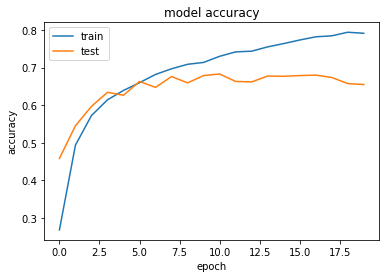

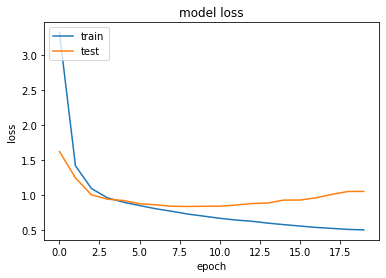

In [25]:
#Let's now plot the differnces in the losses and the accuracies between the training and the test
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()